# Bayesian calibration of a computer code

In this example we are going to compute the parameters of a computer model thanks to Bayesian estimation.

Let us denote $\underline y = (y_1, \dots, y_n)$ the observation sample, $\underline z = (f(x_1|\underline{\theta}), \ldots, f(x_n|\underline{\theta}))$ the model prediction, $p(y |z)$ the density function of observation $y$ conditional on model prediction $z$, and $\underline{\theta} \in \mathbb{R}^p$ the calibration parameters we wish to estimate.


The posterior distribution is given by Bayes theorem:

$$\pi(\underline{\theta} | \underline y) \quad \substack{~\\[0.5em]\displaystyle\propto\\\scriptstyle\underline{\theta}} \quad L\left(\underline y | \underline{\theta}\right) \times \pi(\underline{\theta})$$

(where $\substack{~\\[0.5em]\displaystyle\propto\\\scriptstyle\underline{\theta}}$
means "proportional to", regarded as a function of $\underline{\theta}$)
and is approximated here by the empirical distribution of the sample $\underline{\theta}^1, \ldots, \underline{\theta}^N$ generated by the Metropolis-Hastings algorithm. This means that any quantity characteristic of the posterior distribution (mean, variance, quantile, ...) is approximated by its empirical counterpart.



Our model (i.e. the compute code to calibrate) is a standard normal linear regression, where

$$y_i = \theta_1 + x_i \theta_2 + x_i^2 \theta_3 + \varepsilon_i$$

where $\varepsilon_i \stackrel{i.i.d.}{\sim} \mathcal N(0, 1)$
and we use a normal prior on $\underline{\theta}$:

$$\pi(\underline{\theta}) = \mathcal N(0 ; 100 I_3).$$

The following objects need to be defined in order to perform Bayesian calibration:

- The conditional density $p(y|z)$ must be defined as a probability distribution
- The computer model must be implemented thanks to the ParametricFunction class.
  This takes a value of $\underline{\theta}$ as input, and outputs the vector of model predictions $\underline z$,
  as defined above (the vector of covariates $\underline x = (x_1, \ldots, x_n)$ is treated as a known constant).
  When doing that, we have to keep in mind that $z$ will be used as the vector of parameters corresponding
  to the distribution specified for $p(y |z)$. For instance, if $p(y|z)$ is normal,
  this means that $z$ must be a vector containing the mean and variance of $y$
- The prior density $\pi(\underline{\theta})$ encoding the set of possible values for the calibration parameters,
  each value being weighted by its a priori probability, reflecting the beliefs about the possible values
  of $\underline{\theta}$ before consideration of the experimental data.
  Again, this is implemented as a probability distribution
- The Metropolis-Hastings algorithm that samples from the posterior distribution of the calibration parameters
  requires a vector $\underline{\theta}_0$ initial values for the calibration parameters,
  as well as the proposal laws used to update each parameter sequentially.


In [1]:
from __future__ import print_function
import openturns as ot
import math as m

In [2]:
# Number of covariates
covNum = 1
# Dimension of the observations
obsDim = 1
# Dimension of the vector of parameters to calibrate
paramDim = 3
# The number of obesrvations
obsSize = 10

- Define the inputs $x_i$

In [3]:
x = ot.Sample(obsSize, covNum)
for i in range(obsSize):
    x[i, 0] = -2 + 5. * i / 9.
x

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=10 dimension=1 data=[[-2],[-1.44444],[-0.888889],[-0.333333],[0.222222],[0.777778],[1.33333],[1.88889],[2.44444],[3]]

- Define the vector of observations $y_i$

In [4]:
y_obs = ot.Sample(obsSize, obsDim)
y_obs[0, 0] = -9.50794871493506
y_obs[1, 0] = -3.83296694500105
y_obs[2, 0] = -2.44545713047953
y_obs[3, 0] = 0.0803625289211318
y_obs[4, 0] = 1.01898069723583
y_obs[5, 0] = 0.661725805623086
y_obs[6, 0] = -1.57581204592385
y_obs[7, 0] = -2.95308465670895
y_obs[8, 0] = -8.8878164296758
y_obs[9, 0] = -13.0812290405651
y_obs

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=10 dimension=1 data=[[-9.50795],[-3.83297],[-2.44546],[0.0803625],[1.01898],[0.661726],[-1.57581],[-2.95308],[-8.88782],[-13.0812]]

- Define the vector of parameters matching each observation $\theta^i$

In [5]:
p = ot.Sample(obsSize, paramDim)
for i in range(obsSize):
    for j in range(paramDim):
        p[i, j] = (-2 + 5. * i / 9.) ** j
p

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=10 dimension=3 data=[[1,-2,4],[1,-1.44444,2.08642],[1,-0.888889,0.790123],[1,-0.333333,0.111111],[1,0.222222,0.0493827],[1,0.777778,0.604938],[1,1.33333,1.77778],[1,1.88889,3.5679],[1,2.44444,5.97531],[1,3,9]]

- Define the parametric model $z = f(x,\theta)$ that associates each observation $x_i$ and values of the  parameters $\theta_i$ to the parameters of the distribution of the corresponding observation: here $z=(\mu, \sigma)$

In [6]:
fullModel = ot.SymbolicFunction(
    ['p1', 'p2', 'p3', 'x1', 'x2', 'x3'], ['p1*x1+p2*x2+p3*x3', '1.0'])# assume sigma=1 is known
# f:(x1, x2, x3)->(z) with parameters (p1, p2, p3)
model = ot.ParametricFunction(fullModel, list(range(paramDim)), [0.0]*paramDim)

- Define the distribution of observations $\underline{y} | \underline{z}$ conditional on model predictions

Note that its parameter dimension is the one of $\underline{z}$, so the model must be adjusted accordingly

In [7]:
conditional = ot.Normal()
conditional

class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

- Define the the prior distribution $\pi(\underline{\theta})$ of the parameter $\underline{\theta}$

In [8]:
sigma0 = ot.Point(paramDim, 10.0)  # standard deviations
C0 = ot.CorrelationMatrix(paramDim)       # variance matrix
for i in range(paramDim):
    C0[i, i] = sigma0[i] * sigma0[i]

m0 = ot.Point(paramDim, 0.0)      # mean
prior = ot.Normal(m0, C0)
prior.setDescription(['p1', 'p2', 'p3'])
prior

class=Normal name=Normal dimension=3 mean=class=Point name=Unnamed dimension=3 values=[0,0,0] sigma=class=Point name=Unnamed dimension=3 values=[10,10,10] correlationMatrix=class=CorrelationMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[1,0,0,0,1,0,0,0,1]

In [9]:
# Additional inputs for the random walk Metropolis-Hastings
# sampler constructor:

# 1) Initial state: the prior mean
theta0 = prior.getMean()

# 2) Proposal distribution: uniform
proposal = [ot.Uniform(-1., 1.)] * paramDim

# Creation of the Random Walk Metropolis-Hastings (RWMH) sampler
RWMHsampler = ot.RandomWalkMetropolisHastings(
    prior, conditional, model, p, y_obs, theta0, proposal)

In [10]:
# Tuning of the RWMH algorithm:

# 1) Strategy of calibration for the random walk (trivial example: default)
strategy = ot.CalibrationStrategyCollection(paramDim)
RWMHsampler.setCalibrationStrategyPerComponent(strategy)

# 2) Other parameters
RWMHsampler.setVerbose(True)
RWMHsampler.setThinning(1)
RWMHsampler.setBurnIn(2000)

# Ready to generate a sample from the posterior distribution
# of the parameters theta
sampleSize = 10000
sample = RWMHsampler.getSample(sampleSize)

# Look at the acceptance rate
# (basic checking of the efficiency of the tuning;
# value close to 0.2 usually recommended)
print('acceptance rate=', end=' ')
print(RWMHsampler.getAcceptanceRate())

acceptance rate= [0.455417,0.292583,0.13425]


In [11]:
# Build the distribution of the posterior by kernel smoothing
sample = RWMHsampler.getSample(1000)
kernel = ot.KernelSmoothing()
posterior = kernel.build(sample)

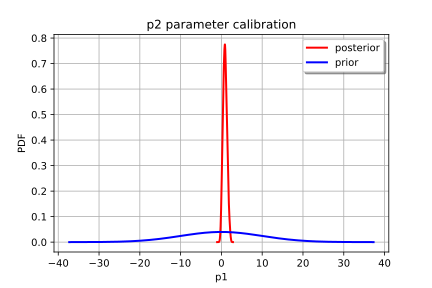

In [12]:
# Display prior vs posterior for p1, the first parameter of the model
p_index = 1
graph = posterior.getMarginal(0).drawPDF()
prior_drawable = prior.getMarginal(0).drawPDF().getDrawable(0)
prior_drawable.setColor('blue')
graph.add(prior_drawable)
graph.setLegends(['posterior', 'prior'])
graph.setTitle('p%d parameter calibration' % (p_index+1))
graph